In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import optuna

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.linear_model import Lasso, LogisticRegression

import catboost
import xgboost as xgb
from xgboost.callback import EarlyStopping
import lightgbm as lgbm

import os
import sys
import datetime

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG
CFG = CFG()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)


In [3]:
from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
grn = Style.BRIGHT + Fore.GREEN
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

rc = {
    "axes.facecolor": "#FFFEF8",
    "figure.facecolor": "#FFFEF8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

In [43]:
orig = pd.read_csv(os.path.join(CFG.RAW_DATA, 'Pulsar.csv'))
train = pd.read_csv(os.path.join(CFG.RAW_DATA, 'train.csv')).drop(columns='id')
test = pd.read_csv(os.path.join(CFG.RAW_DATA, 'test.csv')).drop(columns='id')

In [44]:
train = pd.concat([train, orig]).reset_index(drop=True)
def fe(df):
    df['Mean_DMSNR_Skewness_Ratio'] = df['Mean_DMSNR_Curve'] / df['Skewness_DMSNR_Curve']
    df['SD_Integrated_Skewness_Ratio'] = df['SD'] / df['Skewness']
    df['EK_Integrated_SD_Ratio'] = df['EK'] / df['SD']
    return df

train = fe(train)
test = fe(test)

In [45]:
scaler = RobustScaler()

y = train['Class']
X = train.drop(['Class'], axis=1)

XLR = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
testLR = pd.DataFrame(scaler.transform(test), columns=test.columns)

In [51]:
PATIENCE = 100

modelsCB = []
predsCB = []

k_fold = RepeatedStratifiedKFold(n_splits=CFG.NFOLDS, n_repeats=CFG.REPEATS, random_state=CFG.SEED) 

# gpu_params = {'task_type' : "GPU", 'devices' : '0:1'}
cbr_params = {
            'iterations':9999,
            'depth': 3,
            'learning_rate': 0.15687380686250746,
            'l2_leaf_reg': 4.0368544113430485,
            'random_strength': 0.1279482215776108,
            'max_bin': 238,
            'od_wait': 49,
            'one_hot_max_size': 39,
            'grow_policy': 'SymmetricTree',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            
            
            'random_state': CFG.SEED
        }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = catboost.CatBoostClassifier(**cbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          verbose=150,
         )
    modelsCB.append(model)
    predsCB.append(model.predict_proba(test)[:, 1])

0:	learn: 0.3620267	test: 0.3618927	best: 0.3618927 (0)	total: 147ms	remaining: 24m 30s
150:	learn: 0.0350039	test: 0.0395928	best: 0.0395928 (150)	total: 8.96s	remaining: 9m 44s
300:	learn: 0.0330590	test: 0.0389899	best: 0.0389899 (300)	total: 16.8s	remaining: 9m
450:	learn: 0.0315657	test: 0.0386222	best: 0.0386222 (430)	total: 21.3s	remaining: 7m 31s
600:	learn: 0.0304388	test: 0.0385354	best: 0.0385225 (591)	total: 27.7s	remaining: 7m 12s
750:	learn: 0.0294964	test: 0.0384765	best: 0.0384487 (738)	total: 33s	remaining: 6m 46s
900:	learn: 0.0285405	test: 0.0383582	best: 0.0382951 (849)	total: 37.4s	remaining: 6m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.03829507561
bestIteration = 849

Shrink model to first 850 iterations.
0:	learn: 0.3710474	test: 0.3704227	best: 0.3704227 (0)	total: 40.8ms	remaining: 6m 48s
150:	learn: 0.0358587	test: 0.0360036	best: 0.0360036 (150)	total: 7.74s	remaining: 8m 24s
300:	learn: 0.0340754	test: 0.0357544	best: 0.0357232

In [10]:
def get_fi(model):
    feature_importance =  [model[x].feature_importances_ for x in range(CFG.NFOLDS*CFG.REPEATS)]
    feature_importance = np.average(feature_importance,axis=0)
    feature_df = pd.DataFrame(feature_importance, index=X.columns)

    fig, ax = plt.subplots(figsize=(12, 4))
    sns.barplot(x=feature_df.values.squeeze(), y=feature_df.index,
                color=palette[-3], linestyle="-", width=0.5, errorbar='sd',
                linewidth=0.5, edgecolor="black", ax=ax)
    ax.set_title('Feature Importance', fontdict={'fontweight': 'bold'})
    ax.set(xlabel=None)

    for s in ['right', 'top']:
        ax.spines[s].set_visible(False)

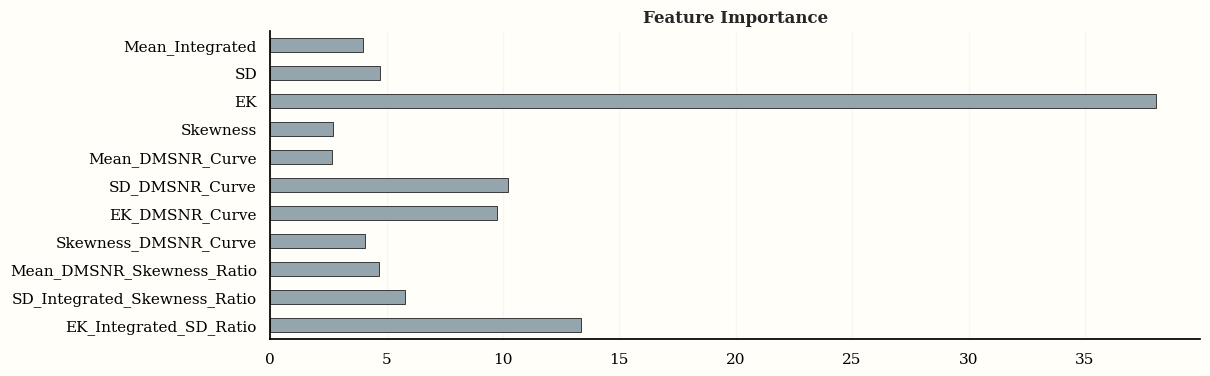

In [8]:
get_fi(modelsCB)

In [50]:
from xgboost import XGBClassifier, XGBRegressor

modelsXB = []
predsXB = []

PATIENCE = 50

xgbr_params = {
            'n_estimators':9999,
            'max_depth': 4,
            'learning_rate': 0.05333221939055333,
            'min_child_weight': 4,
            'gamma': 5.301218558776368e-08,
            'subsample': 0.41010429946197946,
            'colsample_bytree': 0.8298539920447499,
            'reg_alpha': 0.000517878113716743,
            'reg_lambda': 0.00030121415155097723,
            'n_jobs': -1,
            'objective': 'binary:logistic',
            'verbosity': 0,
            'eval_metric': 'logloss',
            'random_state': CFG.SEED}

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = XGBClassifier(**xgbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          verbose = 100
         )
    modelsXB.append(model)
    predsXB.append(model.predict_proba(test)[:, 1])

[0]	validation_0-logloss:0.64315
[100]	validation_0-logloss:0.03966
[200]	validation_0-logloss:0.03798
[300]	validation_0-logloss:0.03791
[330]	validation_0-logloss:0.03793
[0]	validation_0-logloss:0.64314
[100]	validation_0-logloss:0.03688
[200]	validation_0-logloss:0.03527
[300]	validation_0-logloss:0.03505
[352]	validation_0-logloss:0.03508
[0]	validation_0-logloss:0.64321
[100]	validation_0-logloss:0.03878
[200]	validation_0-logloss:0.03708
[298]	validation_0-logloss:0.03701
[0]	validation_0-logloss:0.64321
[100]	validation_0-logloss:0.03884
[200]	validation_0-logloss:0.03726
[300]	validation_0-logloss:0.03684
[400]	validation_0-logloss:0.03656
[444]	validation_0-logloss:0.03656
[0]	validation_0-logloss:0.64316
[100]	validation_0-logloss:0.03885
[200]	validation_0-logloss:0.03733
[300]	validation_0-logloss:0.03714
[353]	validation_0-logloss:0.03733
[0]	validation_0-logloss:0.64319
[100]	validation_0-logloss:0.03735
[200]	validation_0-logloss:0.03561
[283]	validation_0-logloss:0.035

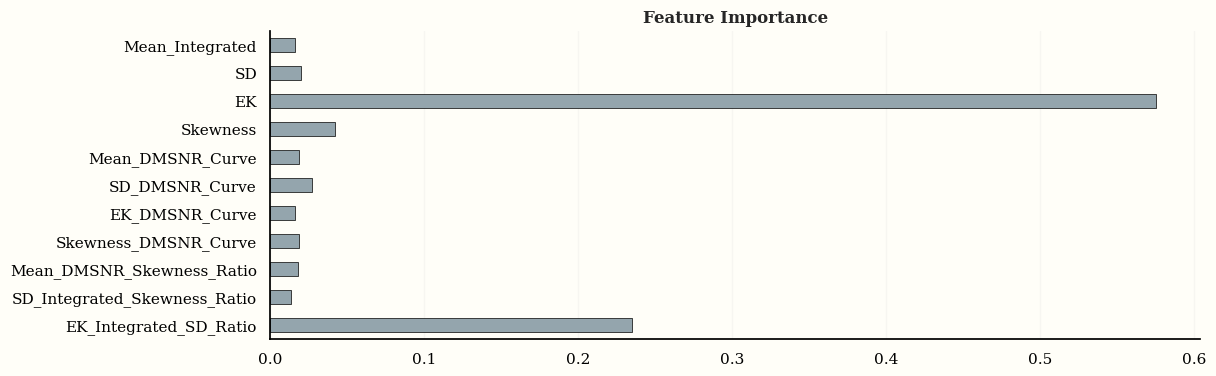

In [11]:
get_fi(modelsXB)

In [52]:
modelsLB = []
predsLB = []

PATIENCE = 50

# gpu_params = {'device' : "gpu"}
lgbr_params = {
            'n_estimators': 9999,
            'max_depth': 5,
            'learning_rate': 0.00693702575527996,
            'subsample': 0.20851841295589477,
            'colsample_bytree': 0.5784778854092203,
            'reg_alpha': 0.2622912287429849,
            'reg_lambda': 2.8702494234117617e-08,
            'objective': 'binary',
            'metric': 'logloss',
            'boosting_type': 'gbdt',
           
            'random_state': CFG.SEED
        }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = lgbm.LGBMClassifier(**lgbr_params)
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          eval_metric = 'logloss',
          early_stopping_rounds = PATIENCE,
          verbose = 100
         )
    modelsLB.append(model)
    predsLB.append(model.predict_proba(test)[:, 1])

[100]	valid_0's binary_logloss: 0.120571
[200]	valid_0's binary_logloss: 0.0732942
[300]	valid_0's binary_logloss: 0.0537599
[400]	valid_0's binary_logloss: 0.045127
[500]	valid_0's binary_logloss: 0.0412931
[600]	valid_0's binary_logloss: 0.0395972
[700]	valid_0's binary_logloss: 0.038848
[800]	valid_0's binary_logloss: 0.038517
[900]	valid_0's binary_logloss: 0.0383455
[1000]	valid_0's binary_logloss: 0.0382409
[1100]	valid_0's binary_logloss: 0.0381807
[1200]	valid_0's binary_logloss: 0.0380993
[1300]	valid_0's binary_logloss: 0.0380346
[1400]	valid_0's binary_logloss: 0.0379798
[1500]	valid_0's binary_logloss: 0.0379484
[1600]	valid_0's binary_logloss: 0.0379233
[1700]	valid_0's binary_logloss: 0.0378984
[100]	valid_0's binary_logloss: 0.119345
[200]	valid_0's binary_logloss: 0.0717541
[300]	valid_0's binary_logloss: 0.0519336
[400]	valid_0's binary_logloss: 0.0431527
[500]	valid_0's binary_logloss: 0.0392017
[600]	valid_0's binary_logloss: 0.0374144
[700]	valid_0's binary_logloss:

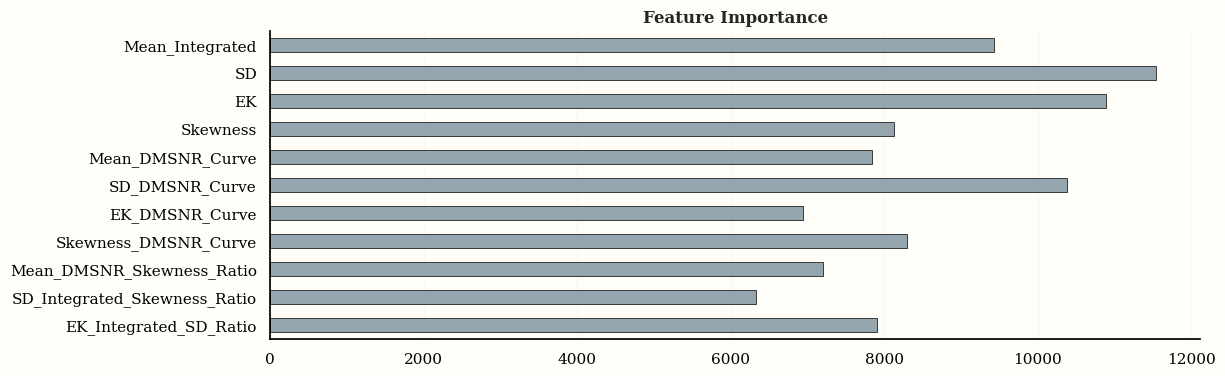

In [16]:
get_fi(modelsLB)

In [58]:
modelsLR = []
predsLR = []
predsLR2 = []

params = {
        'max_iter': 10000,
        'C': 0.1,
        'tol': 0.001029268232213037,
        'n_jobs': -1,
        'random_state': CFG.SEED,
        'verbose': 100
    }

for train_index, test_index in k_fold.split(XLR, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model = LogisticRegression(**params)
    model.fit(X=X_train, y=y_train)
    ypred = model.predict_proba(X_valid)[:, 1]
    score = log_loss(y_valid, ypred)
    print(f'Score: {score}')
    
    modelsLR.append(model)
    predsLR.append(model.predict_proba(testLR)[:, 1])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.8s finished
Score: 0.056492758532931266
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.1s finished
Score: 0.05627772303481176
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.2s finished
Score: 0.05401251493535325
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.9s finished
Score: 0.05642864341826786
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4

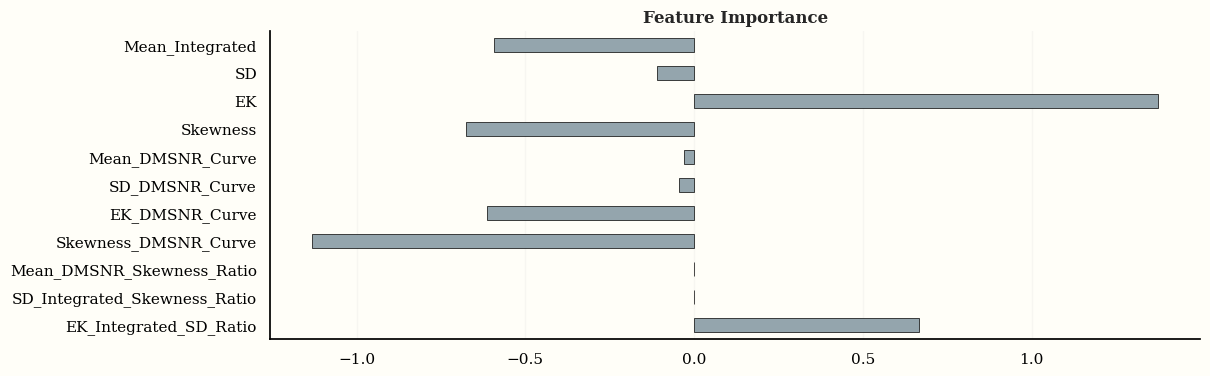

In [38]:
feature_importance =  np.array([modelsLR[x].coef_ for x in range(CFG.NFOLDS*CFG.REPEATS)])
feature_importance = feature_importance.reshape((CFG.NFOLDS*CFG.REPEATS, XLR.shape[1]))
feature_importance = np.average(feature_importance,axis=0)
feature_df = pd.DataFrame(feature_importance, index=X.columns)

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x=feature_df.values.squeeze(), y=feature_df.index,
            color=palette[-3], linestyle="-", width=0.5, errorbar='sd',
            linewidth=0.5, edgecolor="black", ax=ax)
ax.set_title('Feature Importance', fontdict={'fontweight': 'bold'})
ax.set(xlabel=None)

for s in ['right', 'top']:
    ax.spines[s].set_visible(False)

In [59]:
def coef_objective(trial):
    a = trial.suggest_float('a', 0, 1)
    b = trial.suggest_float('b', 0.5, 1)
    c = trial.suggest_float('c', 0.5, 1)
    e = trial.suggest_float('e', 0, 0.1)
    
    preds_eval = []
    for model in modelsCB:
        preds_eval.append(model.predict_proba(X)[:, 1])
    resCB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsXB:
        preds_eval.append(model.predict_proba(X)[:, 1])
    resXB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsLB:
        preds_eval.append(model.predict_proba(X)[:, 1])
    resLB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsLR:
        preds_eval.append(model.predict_proba(XLR[:, 1]))
    resLR = np.average(np.array(preds_eval),axis=0)
    
    res1 =  (resCB * a + resXB * b + resLB * c + resLR * e)/(a + b + c + e)
    res = log_loss(y, res1)
    return res

study = optuna.create_study(direction= 'minimize')

[I 2023-03-13 05:21:59,538] A new study created in memory with name: no-name-f80c4650-b27f-4355-94ea-0f2ff5c5b23b


In [76]:
study.optimize(coef_objective, n_trials=50)
coef_dict = study.best_params
coef_dict

[I 2023-03-13 03:01:04,249] Trial 0 finished with value: 0.08003163247462207 and parameters: {'a': 0.16851633109073927, 'b': 0.6865808449811319, 'c': 0.7333619259545843, 'e': 0.002531054741477019}. Best is trial 0 with value: 0.08003163247462207.
[I 2023-03-13 03:01:30,038] Trial 1 finished with value: 0.0800316506916319 and parameters: {'a': 0.17150189478068645, 'b': 0.9216355399802652, 'c': 0.6281365459071047, 'e': 0.009825720303447512}. Best is trial 0 with value: 0.08003163247462207.
[I 2023-03-13 03:01:54,440] Trial 2 finished with value: 0.08006532704223727 and parameters: {'a': 0.20087089569805727, 'b': 0.6941015622466558, 'c': 0.8279219347697916, 'e': 0.0063946526711473745}. Best is trial 0 with value: 0.08003163247462207.
[I 2023-03-13 03:02:22,016] Trial 3 finished with value: 0.08021165699243608 and parameters: {'a': 0.40149735924707897, 'b': 0.6591764008698964, 'c': 0.8162073707652356, 'e': 0.007034141117414299}. Best is trial 0 with value: 0.08003163247462207.
[I 2023-03-1

{'a': 0.001116156911952916,
 'b': 0.593021413208358,
 'c': 0.5225395657176285,
 'e': 0.0012648566554668578}

In [77]:
coef_dict

{'a': 0.001116156911952916,
 'b': 0.593021413208358,
 'c': 0.5225395657176285,
 'e': 0.0012648566554668578}

In [81]:
predCB = np.average(np.array(predsCB),axis=0)
predXB = np.average(np.array(predsXB),axis=0)
predLB = np.average(np.array(predsLB),axis=0)
predLR = np.average(np.array(predsLR),axis=0)

pred = predCB * coef_dict['a'] + predXB * coef_dict['b'] + predLB * coef_dict['c'] + predLR * coef_dict['e']

In [82]:
submission = pd.read_csv(os.path.join(CFG.DATA_PATH, 'sample_submission.csv'))
submission['Class'] = pred
# submission['Class'] = submission['Class'].clip(0.001, .98)

In [83]:
submission.to_csv(os.path.join(CFG.BASE_PATH, 'submissions', 'CT-XG-LGB-LR_noclippedv2.csv'), index=False)

In [84]:
submission['Class'].values

array([2.02577005e-04, 1.10336084e-03, 1.90590824e-04, ...,
       8.32038226e-05, 6.99263198e-02, 1.09201248e+00])

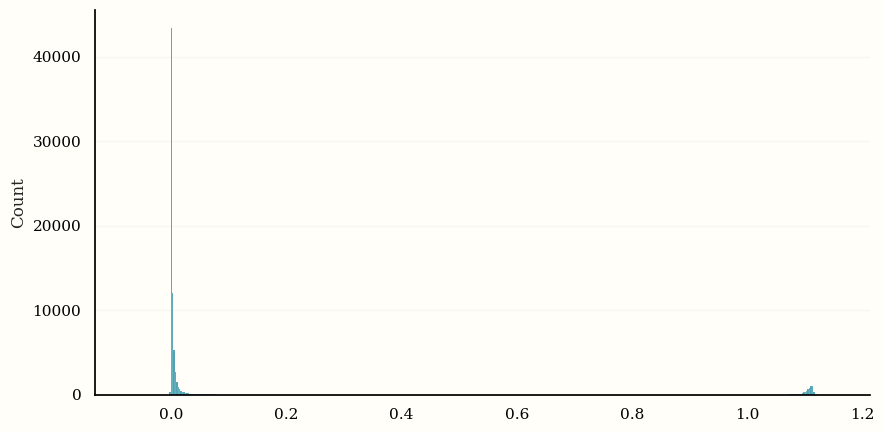

In [80]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(pred, bins=500, color=palette[1], ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(False)
ax.yaxis.grid(True)